# Summary
- mincorr and minlinreg are similar. maxcorr and maxlinreg are similar. 
- spearman among different layers is lower (even goes negative) in lower layers for:
    - bert_large
    - openai
    - bert_base
  
  but not true for elmo or calypso
- intermediate layers appear most similar to the next and previous layer of the same model
- lower layers (eg. in bert) are more correlated with lower layers in other models
- in the larger bert, new layers are effectively inserted between old ones (see heatmap), although the last few layers don't seem to follow this. Corroborates the result in "Similarity of Neural Network Representations Revisited"
- xlnet large and bert large have an interesting relationship. The lower levels of xlnet seem to correspond to the higher layers of bert

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
from ipywidgets import FloatSlider, interactive
import pickle

In [2]:
method_l = [
#     "maxcorr", 
#     "mincorr", 
#     "maxlinreg", 
#     "minlinreg", 
    "cca", 
    # "lincka", 
    # "rbfcka",
]

In [9]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results8_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["cca"]["corrs"]]

# num_neurons_d = {}
# for network in network_l:
#     num_neurons_d[network] = len(next(iter(res_d["maxcorr"]["corrs"][network].values()))) # god this is a hack

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [3]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [4]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = [neuron[0] for neuron in res_d[method][network]]

In [5]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [6]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_large_cased_0
            mincorr   maxcorr  minlinreg  maxlinreg
mincorr    1.000000 -0.265457   0.841917   0.176797
maxcorr   -0.265457  1.000000  -0.205201   0.648580
minlinreg  0.841917 -0.205201   1.000000   0.267656
maxlinreg  0.176797  0.648580   0.267656   1.000000
bert_large_cased_1
            mincorr   maxcorr  minlinreg  maxlinreg
mincorr    1.000000 -0.017512   0.744525   0.035103
maxcorr   -0.017512  1.000000   0.215490   0.966639
minlinreg  0.744525  0.215490   1.000000   0.278610
maxlinreg  0.035103  0.966639   0.278610   1.000000
bert_large_cased_2
            mincorr   maxcorr  minlinreg  maxlinreg
mincorr    1.000000  0.115634   0.739880   0.131480
maxcorr    0.115634  1.000000   0.435666   0.977871
minlinreg  0.739880  0.435666   1.000000   0.452293
maxlinreg  0.131480  0.977871   0.452293   1.000000
bert_large_cased_3
            mincorr   maxcorr  minlinreg  maxlinreg
mincorr    1.000000  0.098167   0.799138   0.121375
maxcorr    0.098167  1.000000   0.348838

### Distributions

In [7]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        corr_ar = np.stack([
            list(notated_neuron[1].values())
            for notated_neuron in res_d[method][network]
        ])
        corr_df = pd.DataFrame(np.abs(corr_ar),
                              columns=[net for net in network_l if net != network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_large_cased_0:

mincorr

maxcounts
bert_large_cased_1                  981
bert_base_cased_0                    40
calypso_transformer_6_512_base_0      2
openai_transformer_2                  1
dtype: int64

mincounts
xlnet_large_cased_23    687
elmo_4x4096_512_2        67
xlnet_large_cased_20     50
xlnet_large_cased_22     34
xlnet_large_cased_16     32
xlnet_large_cased_19     26
xlnet_large_cased_21     20
xlnet_large_cased_18     19
xlnet_large_cased_17     19
xlnet_large_cased_15     18
xlnet_large_cased_13      9
elmo_4x4096_512_3         9
xlnet_large_cased_14      4
xlnet_large_cased_12      3
bert_base_cased_8         3
bert_large_cased_19       2
xlnet_large_cased_1       2
xlnet_large_cased_7       2
elmo_4x4096_512_4         2
bert_large_cased_18       2
xlnet_large_cased_3       2
xlnet_large_cased_9       2
bert_base_cased_12        2
xlnet_large_cased_11      1
bert_large_cased_24       1
bert_large_cased_21       1
xlnet_large_cased_5       1
xlnet_large_cased_

          max       min       med
max  1.000000  0.452293  0.713160
min  0.452293  1.000000  0.881063
med  0.713160  0.881063  1.000000


bert_large_cased_3:

mincorr

maxcounts
bert_large_cased_2    955
bert_large_cased_4     69
dtype: int64

mincounts
xlnet_large_cased_23                574
xlnet_large_cased_22                 65
xlnet_large_cased_20                 48
elmo_4x4096_512_2                    43
xlnet_large_cased_15                 31
xlnet_large_cased_21                 30
xlnet_large_cased_16                 29
elmo_4x4096_512_3                    27
xlnet_large_cased_19                 26
xlnet_large_cased_13                 24
xlnet_large_cased_18                 21
xlnet_large_cased_14                 18
xlnet_large_cased_17                 14
xlnet_large_cased_12                  8
elmo_4x4096_512_4                     6
xlnet_large_cased_11                  5
calypso_transformer_6_512_base_6      4
xlnet_large_cased_8                   4
bert_base_cased_12        


maxcounts
bert_large_cased_6    703
bert_large_cased_4    321
dtype: int64

mincounts
xlnet_large_cased_23                591
xlnet_large_cased_22                 49
elmo_4x4096_512_2                    47
xlnet_large_cased_20                 37
xlnet_large_cased_16                 34
xlnet_large_cased_15                 31
xlnet_large_cased_19                 26
xlnet_large_cased_14                 20
elmo_4x4096_512_3                    20
xlnet_large_cased_18                 18
xlnet_large_cased_17                 18
xlnet_large_cased_13                 17
xlnet_large_cased_21                 13
elmo_4x4096_512_4                    13
xlnet_large_cased_12                 10
elmo_4x4096_512_0                     9
elmo_original_2                       7
openai_transformer_12                 7
openai_transformer_0                  4
bert_base_cased_12                    4
xlnet_large_cased_11                  4
bert_base_cased_11                    4
bert_large_cased_24              


maxcounts
bert_large_cased_6                  744
bert_large_cased_8                  279
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                640
elmo_4x4096_512_2                    44
xlnet_large_cased_22                 38
elmo_4x4096_512_3                    34
xlnet_large_cased_15                 26
xlnet_large_cased_20                 26
xlnet_large_cased_16                 23
xlnet_large_cased_19                 20
xlnet_large_cased_21                 18
xlnet_large_cased_17                 16
xlnet_large_cased_14                 14
xlnet_large_cased_13                 11
openai_transformer_0                 10
elmo_original_0                      10
elmo_original_2                      10
xlnet_large_cased_18                  9
elmo_4x4096_512_4                     9
calypso_transformer_6_512_base_6      7
elmo_4x4096_512_0                     6
xlnet_large_cased_10                  5
bert_base_cased_12                    5
xlnet

openai_transformer_12               658
xlnet_large_cased_23                287
elmo_4x4096_512_0                    33
calypso_transformer_6_512_base_0     31
elmo_original_0                      13
xlnet_large_cased_0                   1
openai_transformer_0                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.612203  0.809070
min  0.612203  1.000000  0.921645
med  0.809070  0.921645  1.000000


bert_large_cased_9:

mincorr

maxcounts
bert_large_cased_10                 668
bert_large_cased_8                  355
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                596
elmo_4x4096_512_2                    47
elmo_4x4096_512_3                    44
xlnet_large_cased_22                 35
xlnet_large_cased_16                 27
xlnet_large_cased_20                 26
xlnet_large_cased_15                 20
elmo_original_0                      18
xlnet_large_cased_19                 16
xlnet_large


maxcounts
bert_large_cased_11    619
bert_large_cased_9     405
dtype: int64

mincounts
openai_transformer_12               753
xlnet_large_cased_23                200
elmo_4x4096_512_0                    37
calypso_transformer_6_512_base_0     19
elmo_original_0                      12
openai_transformer_0                  3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.637688  0.825095
min  0.637688  1.000000  0.927000
med  0.825095  0.927000  1.000000


bert_large_cased_11:

mincorr

maxcounts
bert_large_cased_10    655
bert_large_cased_12    369
dtype: int64

mincounts
xlnet_large_cased_23                632
xlnet_large_cased_22                 43
elmo_4x4096_512_2                    42
elmo_4x4096_512_3                    29
xlnet_large_cased_20                 27
xlnet_large_cased_16                 26
openai_transformer_0                 18
xlnet_large_cased_19                 17
xlnet_large_cased_15                 14
elmo_original_0            


maxcounts
bert_large_cased_13    971
bert_large_cased_11     53
dtype: int64

mincounts
openai_transformer_12               630
elmo_4x4096_512_0                   131
xlnet_large_cased_23                105
calypso_transformer_6_512_base_0     91
elmo_original_0                      59
openai_transformer_0                  8
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.739603  0.872147
min  0.739603  1.000000  0.942765
med  0.872147  0.942765  1.000000


bert_large_cased_13:

mincorr

maxcounts
bert_large_cased_12                 801
bert_large_cased_14                 222
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                665
elmo_4x4096_512_2                    38
xlnet_large_cased_21                 26
openai_transformer_0                 26
xlnet_large_cased_22                 24
elmo_4x4096_512_0                    22
elmo_4x4096_512_3                    22
elmo_original_0                      18
x


maxcounts
bert_large_cased_15    968
bert_large_cased_13     56
dtype: int64

mincounts
elmo_4x4096_512_0                   382
openai_transformer_12               237
calypso_transformer_6_512_base_0    181
elmo_original_0                     150
xlnet_large_cased_23                 37
openai_transformer_0                 29
xlnet_large_cased_0                   8
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.869650  0.915746
min  0.869650  1.000000  0.955152
med  0.915746  0.955152  1.000000


bert_large_cased_15:

mincorr

maxcounts
bert_large_cased_16                 882
bert_large_cased_14                 141
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                633
openai_transformer_0                 32
elmo_4x4096_512_2                    29
elmo_4x4096_512_0                    29
xlnet_large_cased_1                  27
elmo_original_0                      26
elmo_4x4096_512_3                    25
o

          max       min       med
max  1.000000  0.862016  0.903420
min  0.862016  1.000000  0.943259
med  0.903420  0.943259  1.000000

maxlinreg

maxcounts
bert_large_cased_17    768
bert_large_cased_15    256
dtype: int64

mincounts
elmo_4x4096_512_0                   512
calypso_transformer_6_512_base_0    160
openai_transformer_12               153
elmo_original_0                     144
openai_transformer_0                 32
xlnet_large_cased_0                  14
xlnet_large_cased_23                  7
bert_base_cased_0                     2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.862016  0.903420
min  0.862016  1.000000  0.943259
med  0.903420  0.943259  1.000000


bert_large_cased_17:

mincorr

maxcounts
bert_large_cased_16    561
bert_large_cased_18    463
dtype: int64

mincounts
xlnet_large_cased_23                527
elmo_original_0                      53
elmo_4x4096_512_0                    48
openai_transformer_0                 42


          max       min       med
max  1.000000  0.840071  0.881180
min  0.840071  1.000000  0.935872
med  0.881180  0.935872  1.000000

maxlinreg

maxcounts
bert_large_cased_19    1022
bert_large_cased_17       2
dtype: int64

mincounts
elmo_4x4096_512_0                   624
calypso_transformer_6_512_base_0    132
elmo_original_0                     126
openai_transformer_12                99
openai_transformer_0                 32
xlnet_large_cased_23                  6
xlnet_large_cased_0                   4
bert_base_cased_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.840071  0.881180
min  0.840071  1.000000  0.935872
med  0.881180  0.935872  1.000000


bert_large_cased_19:

mincorr

maxcounts
bert_large_cased_20    579
bert_large_cased_18    444
xlnet_large_cased_0      1
dtype: int64

mincounts
xlnet_large_cased_23                403
elmo_original_0                      83
elmo_4x4096_512_3                    59
elmo_4x4096


maxcounts
bert_large_cased_19    991
bert_large_cased_21     33
dtype: int64

mincounts
elmo_4x4096_512_0                   631
openai_transformer_12               118
calypso_transformer_6_512_base_0    109
elmo_original_0                     101
openai_transformer_0                 56
xlnet_large_cased_23                  5
xlnet_large_cased_0                   2
openai_transformer_1                  1
bert_base_cased_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.781412  0.840152
min  0.781412  1.000000  0.932537
med  0.840152  0.932537  1.000000


bert_large_cased_21:

mincorr

maxcounts
bert_large_cased_22    999
bert_large_cased_20     25
dtype: int64

mincounts
xlnet_large_cased_23                327
elmo_4x4096_512_2                    90
elmo_original_0                      73
openai_transformer_0                 64
elmo_4x4096_512_3                    52
elmo_4x4096_512_0                    42
xlnet_large_cased_1        

          max       min       med
max  1.000000  0.749303  0.844573
min  0.749303  1.000000  0.923708
med  0.844573  0.923708  1.000000

maxlinreg

maxcounts
bert_large_cased_23    1020
bert_large_cased_21       4
dtype: int64

mincounts
elmo_4x4096_512_0                   540
openai_transformer_12               167
elmo_original_0                     148
calypso_transformer_6_512_base_0    117
openai_transformer_0                 45
xlnet_large_cased_23                  5
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.749303  0.844573
min  0.749303  1.000000  0.923708
med  0.844573  0.923708  1.000000


bert_large_cased_23:

mincorr

maxcounts
bert_large_cased_22    1023
bert_large_cased_24       1
dtype: int64

mincounts
xlnet_large_cased_23    345
elmo_4x4096_512_2        81
elmo_original_0          68
elmo_4x4096_512_0        58
xlnet_large_cased_2      45
                       ... 
bert_base_cased_5         1


          max       min       med
max  1.000000  0.726249  0.765543
min  0.726249  1.000000  0.959710
med  0.765543  0.959710  1.000000

maxlinreg

maxcounts
bert_large_cased_23    1024
dtype: int64

mincounts
elmo_4x4096_512_0                   485
openai_transformer_12               246
elmo_original_0                     143
xlnet_large_cased_23                 73
calypso_transformer_6_512_base_0     29
xlnet_large_cased_0                  24
openai_transformer_0                 24
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.726249  0.765543
min  0.726249  1.000000  0.959710
med  0.765543  0.959710  1.000000


openai_transformer_0:

mincorr

maxcounts
openai_transformer_1                753
xlnet_large_cased_0                   3
bert_large_cased_0                    2
calypso_transformer_6_512_base_0      2
elmo_4x4096_512_4                     2
elmo_original_1                       2
openai_transformer_10                 1
bert_base_cased_0      


maxcounts
openai_transformer_3    676
openai_transformer_1     90
openai_transformer_4      1
openai_transformer_7      1
dtype: int64

mincounts
xlnet_large_cased_23                414
elmo_4x4096_512_2                    70
elmo_4x4096_512_3                    33
xlnet_large_cased_22                 27
xlnet_large_cased_15                 21
xlnet_large_cased_20                 19
xlnet_large_cased_21                 17
bert_base_cased_12                   17
xlnet_large_cased_17                 12
xlnet_large_cased_13                 12
elmo_4x4096_512_4                    11
xlnet_large_cased_18                 11
xlnet_large_cased_16                 11
bert_large_cased_24                   9
bert_large_cased_22                   7
xlnet_large_cased_14                  7
elmo_original_2                       6
xlnet_large_cased_12                  5
calypso_transformer_6_512_base_6      5
xlnet_large_cased_19                  4
bert_base_cased_11                    4
bert_large_ca

openai_transformer_5    587
openai_transformer_3    181
dtype: int64

mincounts
xlnet_large_cased_23                415
xlnet_large_cased_22                 33
elmo_4x4096_512_3                    33
elmo_4x4096_512_2                    33
bert_large_cased_24                  30
xlnet_large_cased_15                 26
bert_base_cased_12                   20
xlnet_large_cased_20                 16
xlnet_large_cased_14                 16
xlnet_large_cased_21                 15
xlnet_large_cased_13                 14
elmo_4x4096_512_4                    11
xlnet_large_cased_18                 11
xlnet_large_cased_19                 11
bert_large_cased_23                   9
elmo_original_2                       9
xlnet_large_cased_12                  8
calypso_transformer_6_512_base_6      7
xlnet_large_cased_16                  7
xlnet_large_cased_17                  6
xlnet_large_cased_2                   3
bert_base_cased_11                    3
bert_large_cased_15                   3


xlnet_large_cased_23                443
calypso_transformer_6_512_base_0    181
elmo_4x4096_512_0                    96
elmo_original_0                      43
bert_base_cased_0                     3
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.943631  0.969724
min  0.943631  1.000000  0.977448
med  0.969724  0.977448  1.000000

maxlinreg

maxcounts
openai_transformer_7    708
openai_transformer_5     60
dtype: int64

mincounts
xlnet_large_cased_23                443
calypso_transformer_6_512_base_0    181
elmo_4x4096_512_0                    96
elmo_original_0                      43
bert_base_cased_0                     3
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.943631  0.969724
min  0.943631  1.000000  0.977448
med  0.969724  0.977448  1.000000


openai_transformer_7:

mincorr

maxcounts
openai_transformer_8    722
openai_transformer_6

          max       min       med
max  1.000000  0.936367  0.958517
min  0.936367  1.000000  0.973021
med  0.958517  0.973021  1.000000


openai_transformer_9:

mincorr

maxcounts
openai_transformer_8     513
openai_transformer_10    255
dtype: int64

mincounts
xlnet_large_cased_23                415
elmo_original_0                      25
xlnet_large_cased_22                 20
bert_large_cased_24                  17
bert_large_cased_23                  16
bert_large_cased_2                   13
xlnet_large_cased_1                  13
xlnet_large_cased_19                 12
elmo_4x4096_512_0                    12
bert_large_cased_3                   11
xlnet_large_cased_20                 11
bert_large_cased_0                   10
elmo_4x4096_512_2                    10
xlnet_large_cased_17                 10
bert_large_cased_5                   10
xlnet_large_cased_18                  9
bert_base_cased_1                     9
bert_base_cased_12                    9
openai_transformer


maxcounts
openai_transformer_10    429
openai_transformer_12    339
dtype: int64

mincounts
xlnet_large_cased_23    361
elmo_original_0          38
xlnet_large_cased_1      25
bert_large_cased_23      20
bert_large_cased_24      20
                       ... 
elmo_4x4096_512_1         1
bert_large_cased_15       1
bert_base_cased_6         1
bert_base_cased_8         1
xlnet_large_cased_7       1
Length: 62, dtype: int64

corr_df_pctl
          max      min       med
max  1.000000  0.50637  0.487758
min  0.506370  1.00000  0.915490
med  0.487758  0.91549  1.000000

minlinreg

maxcounts
openai_transformer_12    461
openai_transformer_10    307
dtype: int64

mincounts
elmo_4x4096_512_0                   285
elmo_original_0                     204
calypso_transformer_6_512_base_0    196
xlnet_large_cased_23                 68
bert_base_cased_0                     8
xlnet_large_cased_0                   4
openai_transformer_0                  3
dtype: int64

corr_df_pctl
          max    

          max       min       med
max  1.000000  0.450949  0.639903
min  0.450949  1.000000  0.908126
med  0.639903  0.908126  1.000000


bert_base_cased_3:

mincorr

maxcounts
bert_base_cased_4    595
bert_base_cased_2    173
dtype: int64

mincounts
xlnet_large_cased_23                466
xlnet_large_cased_22                 34
elmo_4x4096_512_2                    34
xlnet_large_cased_20                 26
xlnet_large_cased_16                 25
xlnet_large_cased_15                 25
xlnet_large_cased_21                 22
xlnet_large_cased_18                 17
elmo_4x4096_512_3                    16
xlnet_large_cased_17                 15
xlnet_large_cased_19                 10
xlnet_large_cased_14                 10
xlnet_large_cased_12                  8
elmo_4x4096_512_4                     7
calypso_transformer_6_512_base_6      7
xlnet_large_cased_11                  5
elmo_original_0                       5
xlnet_large_cased_13                  4
openai_transformer_12        

bert_base_cased_4    742
bert_base_cased_6     26
dtype: int64

mincounts
xlnet_large_cased_23                526
xlnet_large_cased_20                 33
elmo_4x4096_512_3                    21
elmo_4x4096_512_2                    20
xlnet_large_cased_22                 20
xlnet_large_cased_16                 14
xlnet_large_cased_21                 11
elmo_4x4096_512_0                    11
xlnet_large_cased_15                 11
xlnet_large_cased_17                  8
elmo_original_0                       7
xlnet_large_cased_19                  7
xlnet_large_cased_18                  7
openai_transformer_12                 7
elmo_4x4096_512_4                     6
xlnet_large_cased_1                   6
calypso_transformer_6_512_base_6      5
xlnet_large_cased_10                  4
xlnet_large_cased_12                  4
bert_large_cased_23                   4
xlnet_large_cased_13                  4
elmo_original_2                       4
openai_transformer_0                  4
elmo_4

elmo_4x4096_512_0                   344
openai_transformer_12               156
elmo_original_0                     105
xlnet_large_cased_23                 76
calypso_transformer_6_512_base_0     61
openai_transformer_0                 20
xlnet_large_cased_0                   6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.778019  0.843670
min  0.778019  1.000000  0.922977
med  0.843670  0.922977  1.000000

maxlinreg

maxcounts
bert_base_cased_8    766
bert_base_cased_6      2
dtype: int64

mincounts
elmo_4x4096_512_0                   344
openai_transformer_12               156
elmo_original_0                     105
xlnet_large_cased_23                 76
calypso_transformer_6_512_base_0     61
openai_transformer_0                 20
xlnet_large_cased_0                   6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.778019  0.843670
min  0.778019  1.000000  0.922977
med  0.843670  0.922977  1.000000


bert_base_cased_

          max       min       med
max  1.000000  0.779621  0.822411
min  0.779621  1.000000  0.902546
med  0.822411  0.902546  1.000000


bert_base_cased_10:

mincorr

maxcounts
bert_base_cased_11    765
bert_base_cased_9       3
dtype: int64

mincounts
xlnet_large_cased_23                305
elmo_original_0                      55
elmo_4x4096_512_0                    55
openai_transformer_0                 48
elmo_4x4096_512_2                    39
elmo_4x4096_512_3                    36
xlnet_large_cased_1                  34
openai_transformer_1                 23
xlnet_large_cased_2                  20
xlnet_large_cased_22                 11
xlnet_large_cased_21                  9
bert_large_cased_2                    9
xlnet_large_cased_16                  8
xlnet_large_cased_3                   8
xlnet_large_cased_15                  7
xlnet_large_cased_0                   7
xlnet_large_cased_19                  6
openai_transformer_12                 6
bert_large_cased_0        


maxcounts
bert_base_cased_11       749
openai_transformer_8       4
bert_base_cased_10         4
openai_transformer_7       3
openai_transformer_6       2
bert_large_cased_24        2
openai_transformer_9       2
openai_transformer_10      1
bert_base_cased_8          1
dtype: int64

mincounts
xlnet_large_cased_23                456
xlnet_large_cased_22                 26
elmo_4x4096_512_2                    21
bert_large_cased_5                   20
elmo_4x4096_512_0                    19
elmo_original_0                      17
xlnet_large_cased_21                 17
xlnet_large_cased_1                  17
xlnet_large_cased_20                 16
xlnet_large_cased_18                 15
bert_large_cased_2                   11
xlnet_large_cased_16                 11
xlnet_large_cased_19                 10
elmo_4x4096_512_3                     9
openai_transformer_1                  9
openai_transformer_0                  8
xlnet_large_cased_2                   7
openai_transformer_12   

elmo_original_2                     1017
xlnet_large_cased_0                    3
calypso_transformer_6_512_base_0       1
calypso_transformer_6_512_base_5       1
bert_base_cased_7                      1
calypso_transformer_6_512_base_3       1
dtype: int64

mincounts
xlnet_large_cased_23     523
xlnet_large_cased_22      37
openai_transformer_0      33
xlnet_large_cased_20      24
openai_transformer_12     22
                        ... 
bert_large_cased_13        1
openai_transformer_4       1
bert_base_cased_10         1
openai_transformer_9       1
bert_large_cased_14        1
Length: 71, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.415166  0.375327
min  0.415166  1.000000  0.876993
med  0.375327  0.876993  1.000000

minlinreg

maxcounts
elmo_original_2      1015
elmo_4x4096_512_1       8
elmo_4x4096_512_3       1
dtype: int64

mincounts
openai_transformer_12               491
xlnet_large_cased_23                264
openai_transformer_0            


maxcounts
calypso_transformer_6_512_base_3    905
calypso_transformer_6_512_base_1    119
dtype: int64

mincounts
xlnet_large_cased_23     703
xlnet_large_cased_22      64
xlnet_large_cased_21      29
xlnet_large_cased_20      22
xlnet_large_cased_1       18
xlnet_large_cased_0       16
bert_large_cased_24       16
bert_large_cased_23       10
bert_base_cased_12        10
xlnet_large_cased_18       9
xlnet_large_cased_19       9
xlnet_large_cased_2        8
elmo_4x4096_512_0          8
bert_large_cased_22        7
xlnet_large_cased_14       7
openai_transformer_12      7
xlnet_large_cased_17       7
elmo_4x4096_512_2          6
elmo_original_0            6
xlnet_large_cased_16       4
bert_large_cased_18        3
bert_large_cased_2         3
elmo_original_2            3
xlnet_large_cased_8        3
xlnet_large_cased_12       3
bert_large_cased_21        3
xlnet_large_cased_7        3
bert_base_cased_9          2
xlnet_large_cased_3        2
xlnet_large_cased_4        2
bert_large_case


maxcounts
calypso_transformer_6_512_base_3    963
calypso_transformer_6_512_base_5     61
dtype: int64

mincounts
xlnet_large_cased_23                620
xlnet_large_cased_1                  50
xlnet_large_cased_22                 43
xlnet_large_cased_21                 22
elmo_original_0                      22
xlnet_large_cased_20                 17
elmo_4x4096_512_0                    17
bert_large_cased_24                  16
xlnet_large_cased_0                  16
xlnet_large_cased_2                  14
xlnet_large_cased_17                 12
xlnet_large_cased_18                 11
bert_large_cased_23                  10
bert_base_cased_12                    9
xlnet_large_cased_19                  9
openai_transformer_12                 9
bert_large_cased_22                   9
openai_transformer_5                  9
xlnet_large_cased_16                  8
bert_large_cased_5                    8
xlnet_large_cased_3                   7
xlnet_large_cased_15                  6
opena


maxcounts
elmo_4x4096_512_2    1023
elmo_4x4096_512_3       1
dtype: int64

mincounts
xlnet_large_cased_23     506
xlnet_large_cased_22      38
openai_transformer_12     34
xlnet_large_cased_20      33
xlnet_large_cased_21      31
                        ... 
bert_base_cased_5          1
xlnet_large_cased_8        1
xlnet_large_cased_7        1
openai_transformer_3       1
openai_transformer_4       1
Length: 67, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.263393  0.273977
min  0.263393  1.000000  0.882083
med  0.273977  0.882083  1.000000

minlinreg

maxcounts
elmo_4x4096_512_2    1018
elmo_original_1         6
dtype: int64

mincounts
openai_transformer_12               506
xlnet_large_cased_23                437
openai_transformer_0                 75
openai_transformer_1                  2
calypso_transformer_6_512_base_0      1
bert_base_cased_0                     1
bert_large_cased_24                   1
elmo_original_0                       1
d


maxcounts
xlnet_large_cased_1                 1013
calypso_transformer_6_512_base_0       6
elmo_original_1                        3
bert_large_cased_0                     1
calypso_transformer_6_512_base_1       1
dtype: int64

mincounts
elmo_4x4096_512_2                   129
elmo_4x4096_512_3                    82
calypso_transformer_6_512_base_6     66
bert_large_cased_18                  51
bert_large_cased_23                  51
bert_base_cased_11                   51
bert_base_cased_10                   50
bert_large_cased_22                  46
bert_large_cased_21                  43
bert_base_cased_9                    28
xlnet_large_cased_16                 26
bert_large_cased_14                  25
bert_large_cased_19                  24
bert_large_cased_16                  23
bert_large_cased_17                  22
bert_base_cased_12                   18
bert_large_cased_5                   17
xlnet_large_cased_23                 15
bert_large_cased_24                  15



maxcounts
xlnet_large_cased_3    1023
xlnet_large_cased_1       1
dtype: int64

mincounts
elmo_4x4096_512_2                   92
elmo_4x4096_512_3                   82
bert_large_cased_22                 82
calypso_transformer_6_512_base_6    79
bert_base_cased_12                  60
                                    ..
openai_transformer_9                 1
openai_transformer_4                 1
openai_transformer_8                 1
xlnet_large_cased_20                 1
xlnet_large_cased_17                 1
Length: 62, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.120712  0.132365
min  0.120712  1.000000  0.909873
med  0.132365  0.909873  1.000000

minlinreg

maxcounts
xlnet_large_cased_3    1024
dtype: int64

mincounts
openai_transformer_12               939
xlnet_large_cased_23                 63
bert_large_cased_24                  11
bert_base_cased_12                    9
calypso_transformer_6_512_base_0      1
elmo_4x4096_512_0              

          max       min       med
max  1.000000  0.454119  0.388617
min  0.454119  1.000000  0.883321
med  0.388617  0.883321  1.000000

maxcorr

maxcounts
xlnet_large_cased_7                 547
xlnet_large_cased_5                 476
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
openai_transformer_0                72
elmo_4x4096_512_2                   60
bert_large_cased_2                  60
elmo_original_0                     58
elmo_4x4096_512_0                   54
                                    ..
calypso_transformer_6_512_base_5     2
calypso_transformer_6_512_base_4     2
bert_base_cased_5                    2
bert_base_cased_6                    1
xlnet_large_cased_1                  1
Length: 61, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.454119  0.388617
min  0.454119  1.000000  0.883321
med  0.388617  0.883321  1.000000

minlinreg

maxcounts
xlnet_large_cased_7    1023
xlnet_large_cased_5       1
dtype: int64

minc


maxcounts
xlnet_large_cased_9     787
xlnet_large_cased_11    237
dtype: int64

mincounts
openai_transformer_0                87
elmo_4x4096_512_0                   86
elmo_original_0                     76
bert_large_cased_2                  73
bert_large_cased_3                  53
elmo_4x4096_512_2                   47
bert_large_cased_5                  44
bert_base_cased_1                   44
bert_large_cased_4                  44
elmo_4x4096_512_3                   34
bert_large_cased_1                  33
bert_large_cased_24                 30
bert_base_cased_0                   29
bert_large_cased_0                  24
bert_large_cased_6                  23
bert_large_cased_22                 21
bert_base_cased_2                   21
bert_base_cased_12                  20
calypso_transformer_6_512_base_0    20
bert_large_cased_23                 19
openai_transformer_12               16
openai_transformer_1                16
bert_large_cased_21                 12
bert_large_c


maxcounts
xlnet_large_cased_15    974
xlnet_large_cased_13     50
dtype: int64

mincounts
elmo_original_0                     95
elmo_4x4096_512_0                   75
elmo_4x4096_512_2                   70
bert_large_cased_2                  66
bert_large_cased_3                  59
bert_large_cased_5                  54
elmo_4x4096_512_3                   52
openai_transformer_0                50
bert_large_cased_1                  41
bert_large_cased_4                  37
bert_base_cased_1                   37
bert_base_cased_2                   34
bert_base_cased_0                   29
openai_transformer_1                25
bert_large_cased_23                 20
calypso_transformer_6_512_base_0    19
openai_transformer_2                19
bert_large_cased_22                 18
bert_large_cased_24                 18
bert_large_cased_6                  18
bert_large_cased_0                  18
openai_transformer_12               12
bert_base_cased_3                   11
bert_base_ca


maxcounts
xlnet_large_cased_19    892
xlnet_large_cased_17    132
dtype: int64

mincounts
elmo_4x4096_512_2                   118
elmo_4x4096_512_0                    90
elmo_original_0                      74
openai_transformer_0                 66
elmo_4x4096_512_3                    58
                                   ... 
openai_transformer_6                  1
bert_large_cased_18                   1
openai_transformer_4                  1
xlnet_large_cased_3                   1
calypso_transformer_6_512_base_2      1
Length: 62, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.530406  0.470217
min  0.530406  1.000000  0.919656
med  0.470217  0.919656  1.000000

minlinreg

maxcounts
xlnet_large_cased_19    1020
xlnet_large_cased_17       4
dtype: int64

mincounts
elmo_4x4096_512_0                   543
calypso_transformer_6_512_base_0    167
elmo_original_0                     147
openai_transformer_0                143
bert_base_cased_0             


maxcounts
xlnet_large_cased_21    1015
xlnet_large_cased_23       8
xlnet_large_cased_0        1
dtype: int64

mincounts
elmo_4x4096_512_2                   147
elmo_original_0                      75
openai_transformer_0                 68
elmo_4x4096_512_3                    59
elmo_4x4096_512_0                    58
                                   ... 
calypso_transformer_6_512_base_1      1
openai_transformer_3                  1
openai_transformer_4                  1
calypso_transformer_6_512_base_3      1
bert_base_cased_5                     1
Length: 66, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.335521  0.301773
min  0.335521  1.000000  0.919164
med  0.301773  0.919164  1.000000

minlinreg

maxcounts
xlnet_large_cased_21    1018
xlnet_large_cased_23       6
dtype: int64

mincounts
elmo_4x4096_512_0                   590
calypso_transformer_6_512_base_0    169
elmo_original_0                     134
openai_transformer_0                104

# LinCKA

In [8]:
lincka_d = torch.load(res_fname["lincka"])
lincka_df = pd.DataFrame(lincka_d)

In [9]:
network = "bert_large_cased_0"
lincka_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.202053
xlnet_large_cased_22                0.351866
bert_large_cased_23                 0.354740
calypso_transformer_6_512_base_6    0.355555
bert_large_cased_21                 0.361211
                                      ...   
bert_large_cased_2                  0.845682
bert_base_cased_1                   0.865026
bert_large_cased_1                  0.913526
bert_base_cased_0                   0.934164
bert_large_cased_0                       NaN
Name: bert_large_cased_0, Length: 90, dtype: float64

# RBFCKA

In [10]:
rbfcka_d = torch.load(res_fname["rbfcka"])
rbfcka_df = pd.DataFrame(rbfcka_d)

In [11]:
rbfcka_df

,bert_large_cased_0,bert_large_cased_1,bert_large_cased_2,bert_large_cased_3,bert_large_cased_4,bert_large_cased_5,bert_large_cased_6,bert_large_cased_7,bert_large_cased_8,bert_large_cased_9,...,xlnet_large_cased_14,xlnet_large_cased_15,xlnet_large_cased_16,xlnet_large_cased_17,xlnet_large_cased_18,xlnet_large_cased_19,xlnet_large_cased_20,xlnet_large_cased_21,xlnet_large_cased_22,xlnet_large_cased_23
bert_large_cased_1,0.958923,NaN,0.962333,0.938055,0.921050,0.886039,0.844627,0.814251,0.792412,0.783580,...,0.464779,0.453394,0.447062,0.449280,0.458350,0.452942,0.437514,0.454656,0.385068,0.240834
bert_large_cased_2,0.907885,0.962333,NaN,0.983571,0.961640,0.920335,0.870890,0.833937,0.812005,0.801698,...,0.466762,0.458272,0.454303,0.453605,0.463618,0.456997,0.442338,0.458592,0.387294,0.251181
bert_large_cased_3,0.888113,0.938055,0.983571,NaN,0.978484,0.935028,0.881890,0.840889,0.817723,0.808441,...,0.463370,0.455872,0.453373,0.451785,0.461610,0.454229,0.439893,0.456138,0.384465,0.253966
bert_large_cased_4,0.864902,0.921050,0.961640,0.978484,NaN,0.972757,0.928001,0.888479,0.862549,0.849075,...,0.483525,0.474209,0.470270,0.467358,0.476848,0.467652,0.453449,0.467788,0.392557,0.253440
bert_large_cased_5,0.826204,0.886039,0.920335,0.935028,0.972757,NaN,0.970004,0.931717,0.902825,0.884260,...,0.502819,0.491814,0.486593,0.483788,0.491712,0.480648,0.466078,0.478037,0.398950,0.252465
bert_large_cased_6,0.782213,0.844627,0.870890,0.881890,0.928001,0.970004,NaN,0.972245,0.942274,0.919822,...,0.524838,0.511804,0.504118,0.502479,0.509828,0.498159,0.482765,0.491824,0.410311,0.252229
bert_large_cased_7,0.750540,0.814251,0.833937,0.840889,0.888479,0.931717,0.972245,NaN,0.976091,0.949220,...,0.533819,0.519408,0.510375,0.509812,0.517959,0.507673,0.492784,0.499720,0.416375,0.251230
bert_large_cased_8,0.726120,0.792412,0.812005,0.817723,0.862549,0.902825,0.942274,0.976091,NaN,0.974150,...,0.535587,0.521849,0.512539,0.511574,0.519171,0.509611,0.494794,0.501132,0.417967,0.250896
bert_large_cased_9,0.718750,0.783580,0.801698,0.808441,0.849075,0.884260,0.919822,0.949220,0.974150,NaN,...,0.546082,0.532015,0.521162,0.519159,0.525164,0.514975,0.499747,0.505142,0.422730,0.252197
bert_large_cased_10,0.736424,0.792640,0.808833,0.816050,0.851413,0.879319,0.906516,0.927962,0.946127,0.973856,...,0.563628,0.548852,0.537017,0.533810,0.539472,0.528313,0.511396,0.516359,0.433111,0.258353


In [12]:
network = "bert_large_cased_0"
rbfcka_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.232348
bert_large_cased_23                 0.365067
xlnet_large_cased_22                0.366753
bert_large_cased_21                 0.369674
calypso_transformer_6_512_base_6    0.374850
                                      ...   
bert_large_cased_2                  0.907885
bert_base_cased_1                   0.911293
bert_large_cased_1                  0.958923
bert_base_cased_0                   0.959785
bert_large_cased_0                       NaN
Name: bert_large_cased_0, Length: 90, dtype: float64

# CCA

In [22]:
corrs, sv_similarities, pw_similarities = res_d['cca']['corrs'], res_d['cca']['sv_similarities'], res_d['cca']['pw_similarities']

In [23]:
sv_sim_df = pd.DataFrame(sv_similarities)
pw_sim_df = pd.DataFrame(pw_similarities)
corrs_df = pd.DataFrame(corrs)
maxcorrs_df = corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

In [24]:
pw_sim_df

,elmo_original_0,elmo_original_1,elmo_original_2
elmo_original_1,0.614226,NaN,0.697670
elmo_original_2,0.490601,0.701596,NaN
elmo_original_0,NaN,0.598978,0.471365


### SVCCA

In [26]:
network = "elmo_original_0"
sv_sim_df.sort_values(by=network)[network]

elmo_original_2    0.404964
elmo_original_1    0.531194
elmo_original_0         NaN
Name: elmo_original_0, dtype: float64

### PWCCA

In [27]:
network = "elmo_original_0"
pw_sim_df.sort_values(by=network)[network]

elmo_original_2    0.490601
elmo_original_1    0.614226
elmo_original_0         NaN
Name: elmo_original_0, dtype: float64

### Heatmaps

In [28]:
plt.rcParams["figure.figsize"] = (20,15)

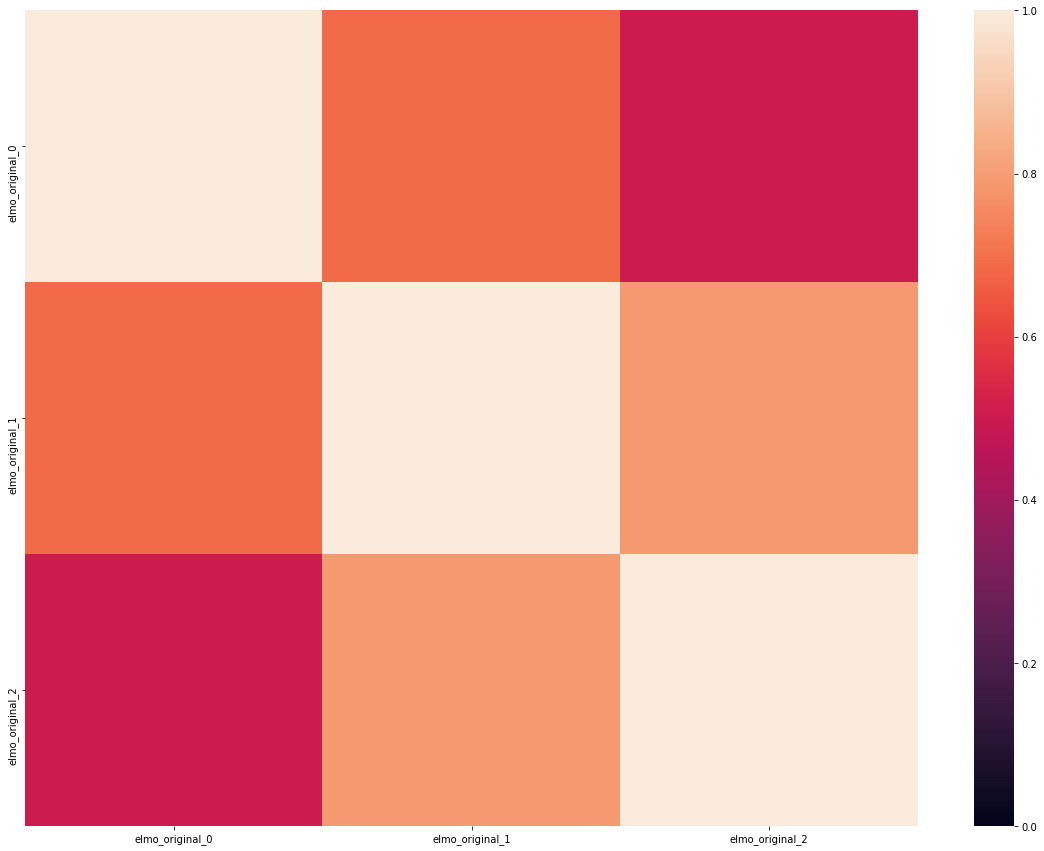

In [29]:
# lincka
sns.heatmap(lincka_df.reindex(lincka_df.columns).fillna(1), vmin=0, vmax=1)

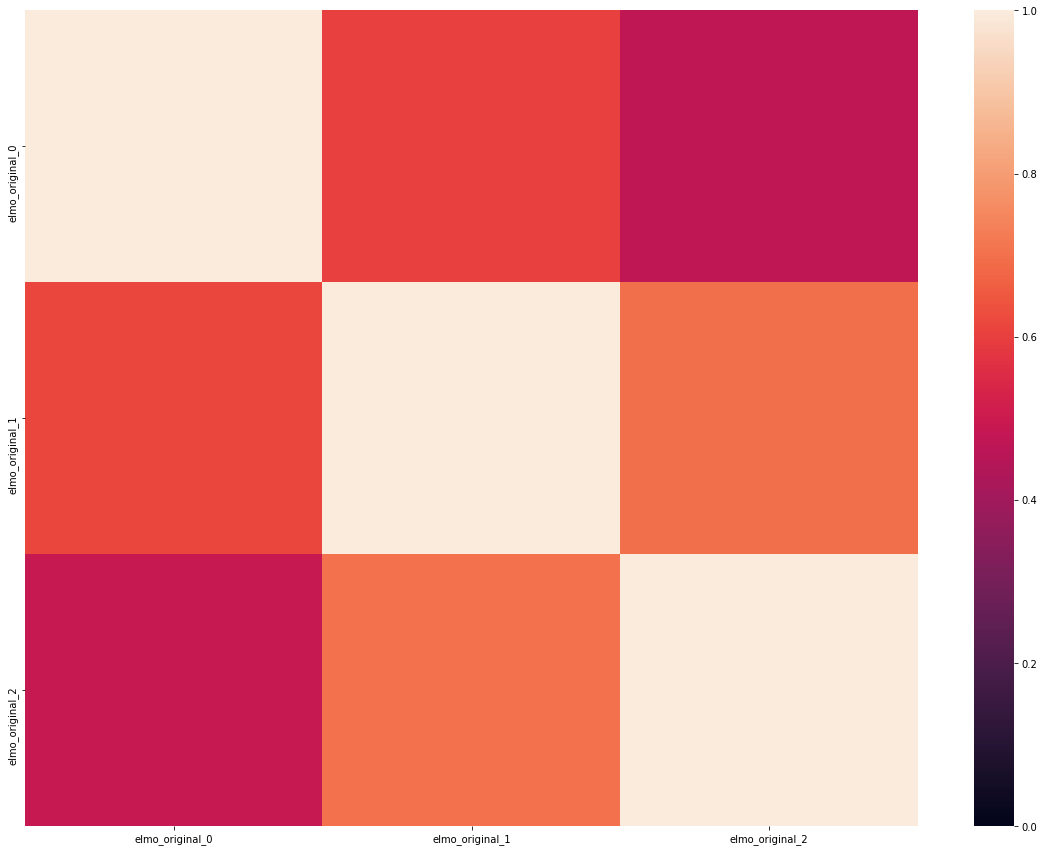

In [30]:
# pwcca
sns.heatmap(pw_sim_df.reindex(pw_sim_df.columns).fillna(1), vmin=0, vmax=1)

In [ ]:
plt.savefig?

In [31]:
memo = {}
fname = "temp_"
def sv_update(f):
    fname = "{0:.2f}.png".format(f)
    try:
        plt.imshow(fname+"{0:.2f}".format(f))
    except:
        pass
    
    try:
        df = memo[f]
    except:
        df = corrs_df.applymap(lambda t: float('nan') if type(t) is float else t[:int(f*len(t))].mean().item())
    sns.heatmap(df.fillna(1), vmin=0, vmax=1)
    # sns.heatmap(df.fillna(1), )
    plt.savefig(fname)
    plt.show()
slider = FloatSlider(min=0, max=1, step=0.1)

interactive(sv_update, f=slider)

interactive(children=(FloatSlider(value=0.0, description='f', max=1.0), Output()), _dom_classes=('widget-inter…

In [ ]:
# rbfcka
sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [ ]:
# comparing models
# use lincka
model1 = "openai"
model2 = "xlnet"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

In [ ]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()